In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
 import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import sobel
from skimage.filters import scharr

In [5]:
data_dir = 'D:/archive/Mango DataSet1/MangoLeafBD Dataset'
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation')

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


Found 4000 images belonging to 8 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08661567..1.1567765].


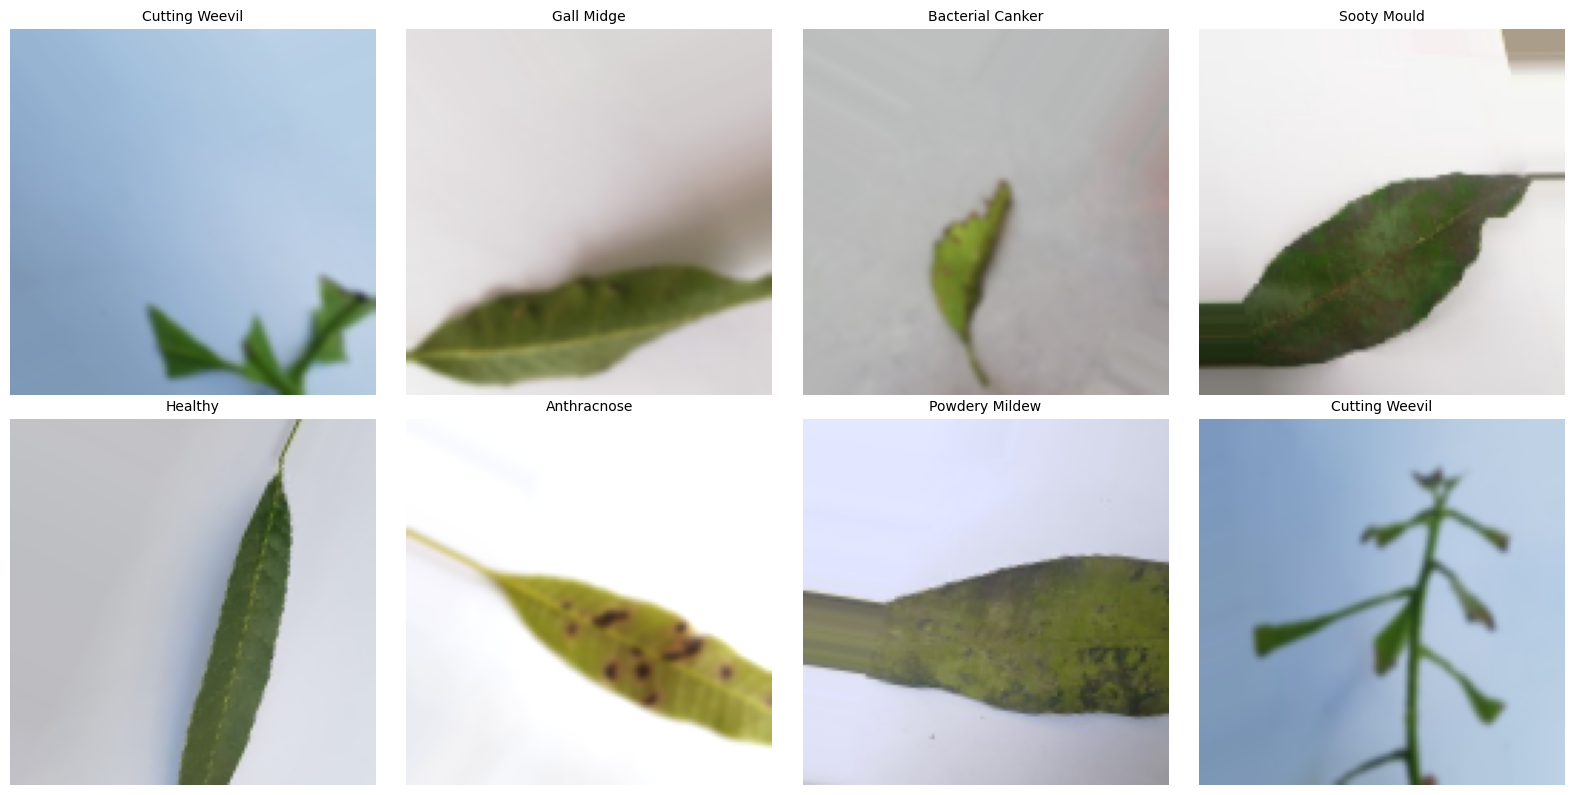

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from imgaug import augmenters as iaa

# Function for custom augmentation (Gaussian blur, Linear contrast, etc.)
def custom_augment(image):
    # Convert to numpy array
    image = np.array(image)
    
    # Gaussian Blur
    if np.random.rand() > 0.5:  # Apply with 50% probability
        image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Linear Contrast
    if np.random.rand() > 0.5:  # Apply with 50% probability
        contrast = iaa.LinearContrast((0.75, 1.5))  # Random contrast adjustment
        image = contrast.augment_image(image)

    return image

# Define the ImageDataGenerator with standard augmentations
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Random rotations
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    shear_range=20,         # Shear transformation
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Horizontal flip
    fill_mode='nearest'     # Filling strategy for new pixels
)

# Example: Custom augmentation for one batch
def augment_and_display(data_dir):
    # Load and augment images
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),  # Resize images
        batch_size=8,           # Generate 8 images for visualization
        class_mode='categorical'  # Include labels
    )
    
    # Get one batch of images and labels
    images, labels = next(generator)
    augmented_images = [custom_augment(img) for img in images]
    
    # Get class labels
    class_indices = generator.class_indices
    label_map = {v: k for k, v in class_indices.items()}  # Map indices to class names
    label_names = [label_map[np.argmax(lbl)] for lbl in labels]
    
    # Plot original and augmented images with labels
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    for img, label, ax in zip(augmented_images, label_names, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label, fontsize=10)  # Set label as title
    plt.tight_layout()
    plt.show()

# Replace 'data_dir' with the path to your dataset
augment_and_display("D:/archive/Mango DataSet1/MangoLeafBD Dataset")


Loading image from: D:/archive/Mango DataSet1/MangoLeafBD Dataset/Anthracnose\20211011_134558 (Custom).jpg


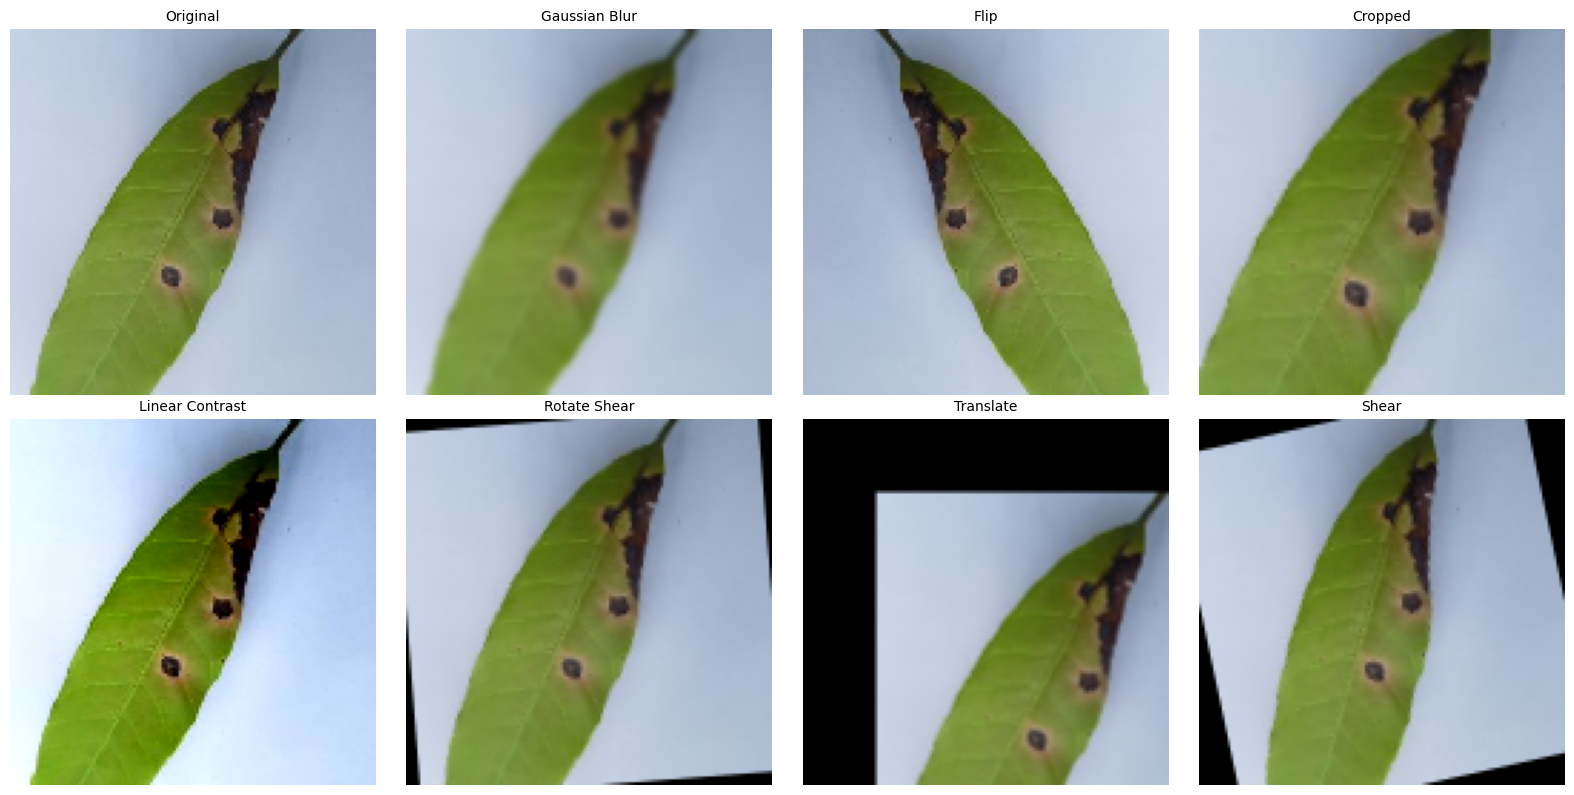

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
from imgaug import augmenters as iaa
import os

# Define custom augmentations
def augmentations_pipeline(image):
    augmented_images = {}

    # 1. Original Image
    augmented_images["Original"] = image

    # 2. Gaussian Blur
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    augmented_images["Gaussian Blur"] = blurred

    # 3. Flip (Horizontal Flip)
    flipped = cv2.flip(image, 1)
    augmented_images["Flip"] = flipped

    # 4. Cropped (Center Crop)
    height, width = image.shape[:2]
    cropped = image[int(0.1 * height):int(0.9 * height), int(0.1 * width):int(0.9 * width)]
    cropped = cv2.resize(cropped, (width, height))  # Resize back to original size
    augmented_images["Cropped"] = cropped

    # 5. Linear Contrast
    contrast = iaa.LinearContrast((1.5))  # Increase contrast
    contrasted = contrast.augment_image(image)
    augmented_images["Linear Contrast"] = contrasted

    # 6. Rotate Shear
    rotate_shear = iaa.Affine(rotate=(-25, 25), shear=(-15, 15))
    rotated_sheared = rotate_shear.augment_image(image)
    augmented_images["Rotate Shear"] = rotated_sheared

    # 7. Translate
    translate = iaa.Affine(translate_percent={"x": 0.2, "y": 0.2})
    translated = translate.augment_image(image)
    augmented_images["Translate"] = translated

    # 8. Shear
    shear = iaa.Affine(shear=(-20, 20))
    sheared = shear.augment_image(image)
    augmented_images["Shear"] = sheared

    return augmented_images

# Display the augmentations
def display_augmentations(data_dir, image_filename):
    # Load the original image
    image_path = os.path.join(data_dir, image_filename)  # Correctly join the path
    print(f"Loading image from: {image_path}")  # Debugging line to verify the path
    
    try:
        original_image = load_img(image_path, target_size=(128, 128))
        original_image = img_to_array(original_image).astype(np.uint8)
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    # Apply augmentations
    augmented_images = augmentations_pipeline(original_image)

    # Plot augmented images
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    for ax, (aug_name, aug_image) in zip(axes, augmented_images.items()):
        ax.imshow(aug_image)
        ax.axis('off')
        ax.set_title(aug_name, fontsize=10)
    plt.tight_layout()
    plt.show()

# Replace 'data_dir' with your dataset directory and provide a sample image name
display_augmentations("D:/archive/Mango DataSet1/MangoLeafBD Dataset/Anthracnose", "20211011_134558 (Custom).jpg")  # Update path with the correct filename


In [11]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [13]:
print(class_weights)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}


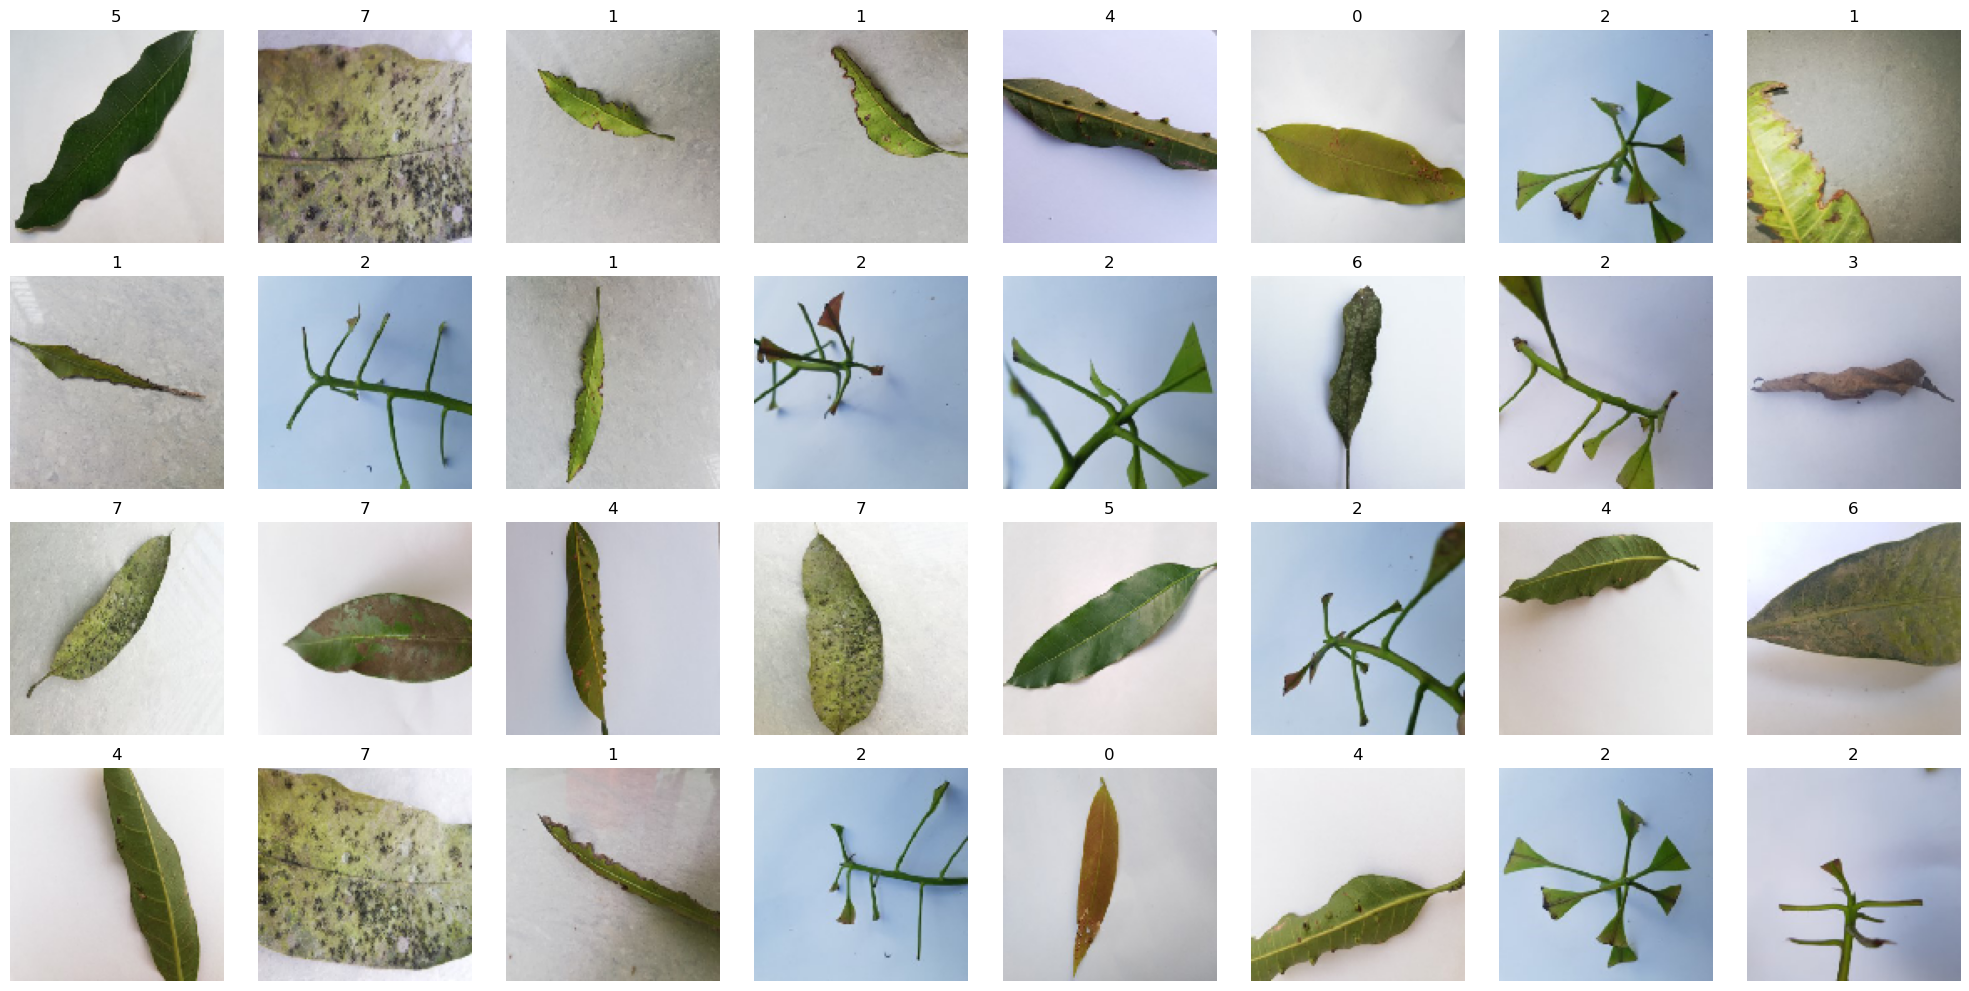

In [15]:
images, labels = next(train_generator)

def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_images(images, labels)

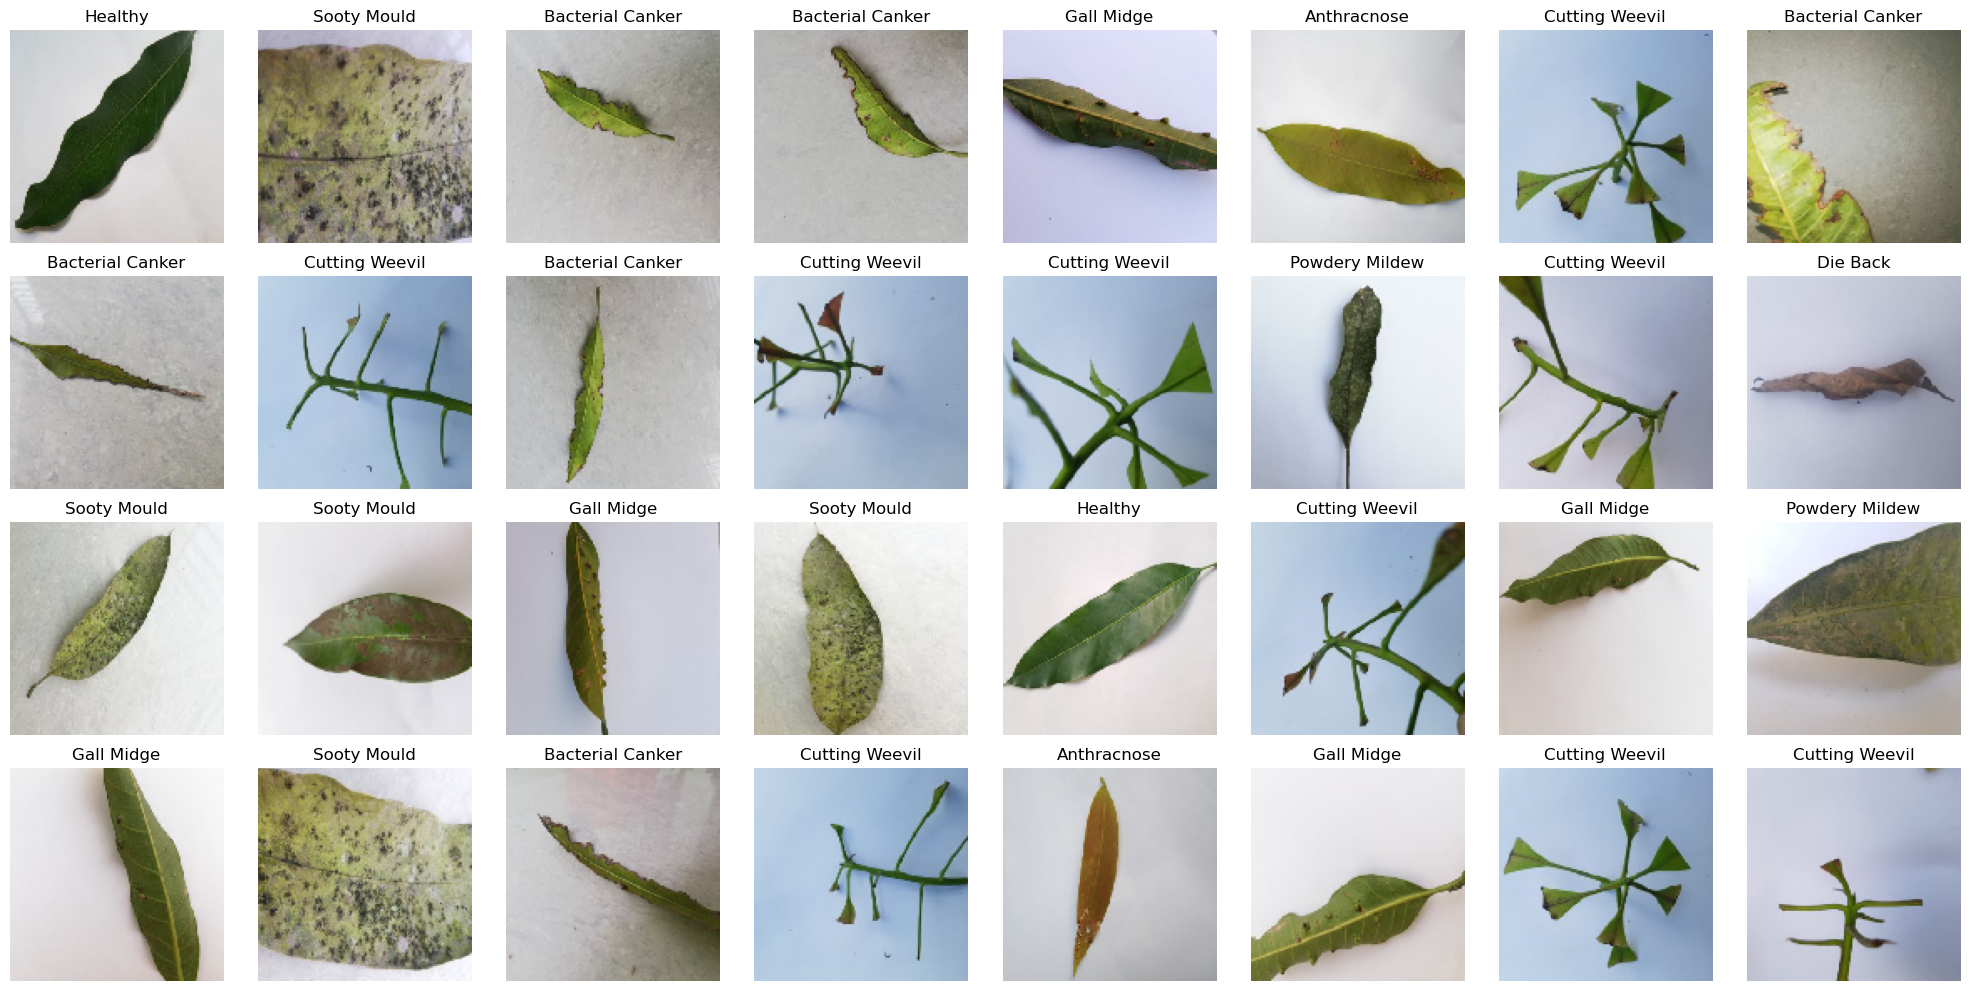

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define label mapping
label_mapping = {0: "Anthracnose", 1: "Bacterial Canker", 2: "Cutting Weevil", 3: "Die Back", 4:"Gall Midge",5:"Healthy",6:"Powdery Mildew",7:"Sooty Mould"}

def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        # Get the label name using the mapping dictionary
        ax.set_title(label_mapping[np.argmax(lbl)])
    plt.tight_layout()
    plt.show()

# Call the function
plot_images(images, labels)


In [19]:
def apply_sobel(images_arr):
    sobel_images = []
    for img in images_arr:
        gray_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        sobel_x = sobel(gray_img, axis=0, mode='constant')
        sobel_y = sobel(gray_img, axis=1, mode='constant')
        sobel_img = np.hypot(sobel_x, sobel_y)
        sobel_images.append(sobel_img)
    return np.array(sobel_images)

sobel_images = apply_sobel(images)

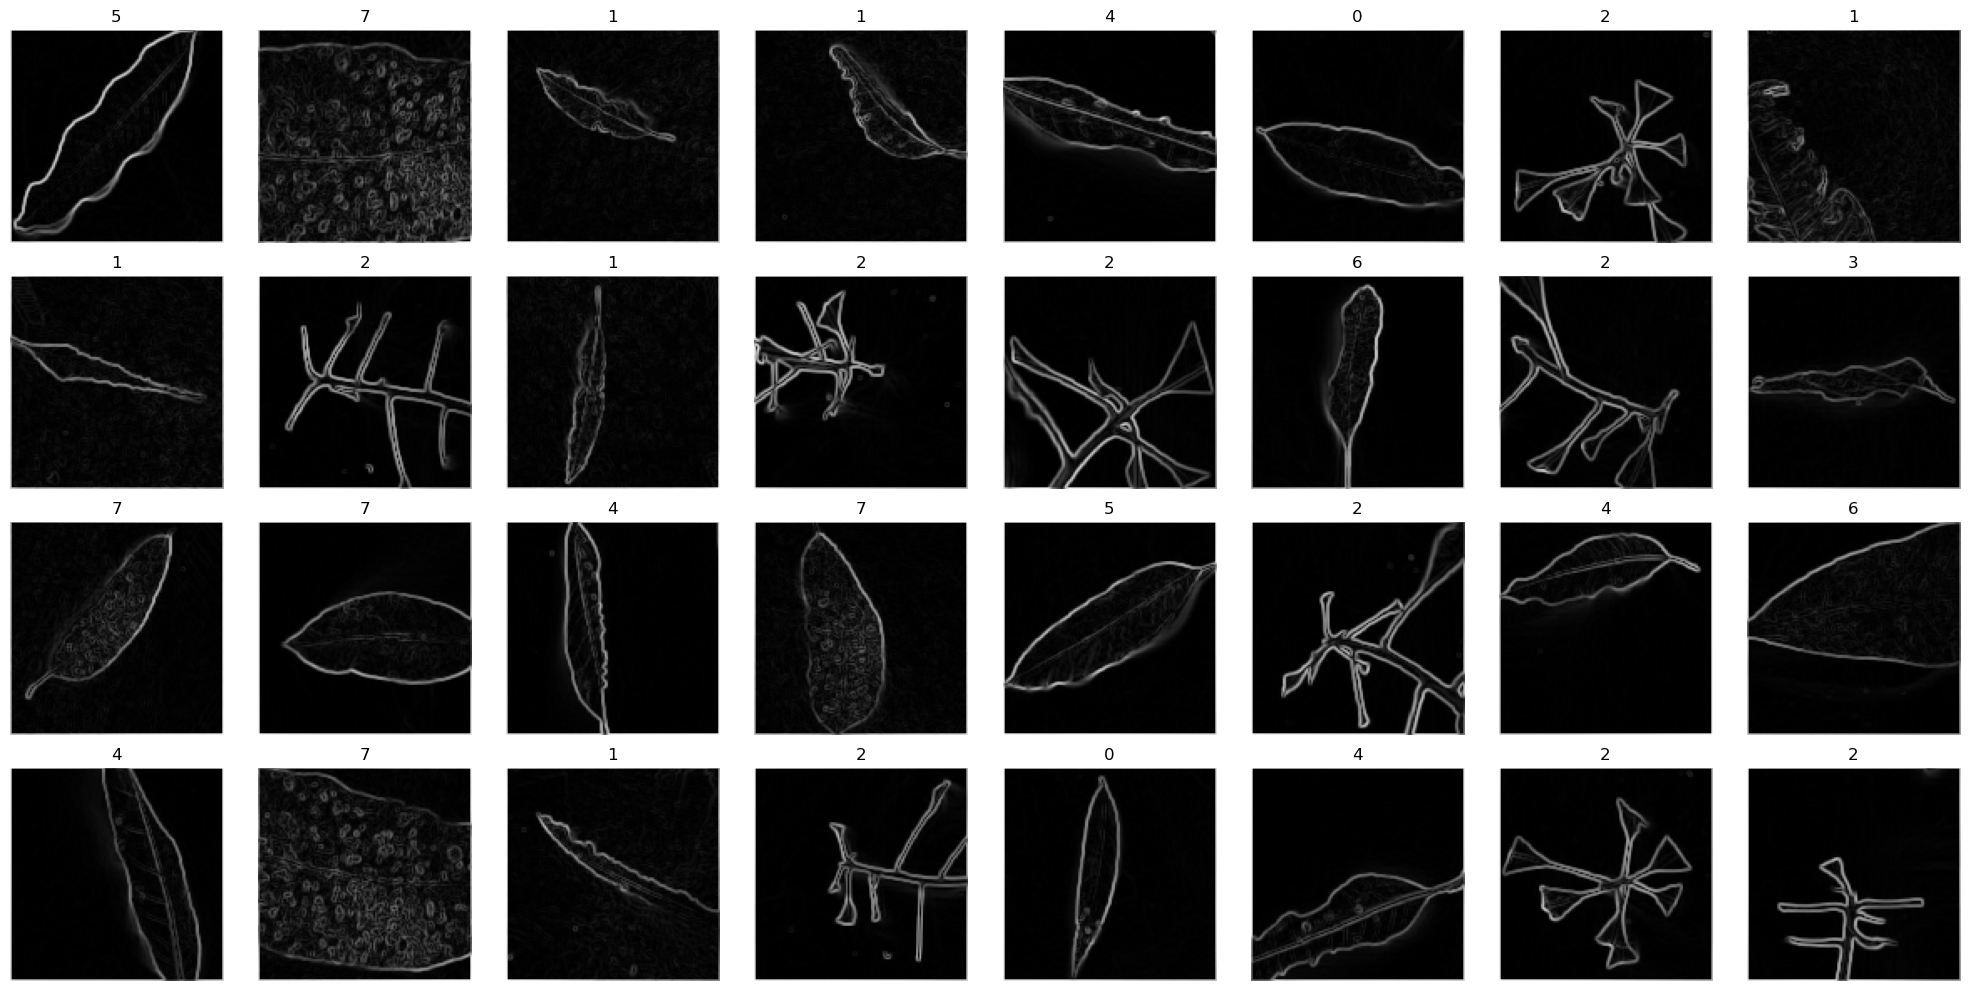

In [21]:
def plot_sobel_images(original_images, sobel_images, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for orig_img, sob_img, lbl, ax in zip(original_images, sobel_images, labels_arr, axes):
        ax.imshow(sob_img, cmap='gray')
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_sobel_images(images, sobel_images, labels)

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Concatenate,
    GlobalAveragePooling2D,
    BatchNormalization,
    Activation,
    Flatten,
    Dense
)
from tensorflow.keras.models import Model


def fire_module(x, squeeze_filters, expand_filters):
    """
    A Fire module with squeeze and expand operations.

    Args:
        x: Input tensor.
        squeeze_filters: Number of filters for the squeeze layer.
        expand_filters: Number of filters for the expand layer.

    Returns:
        Output tensor after the fire module.
    """
    # Squeeze operation
    squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='valid')(x)
    squeeze = BatchNormalization()(squeeze)

    # Expand operation
    expand_1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='valid')(squeeze)
    expand_3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)

    # Concatenate the 1x1 and 3x3 expansions
    output = Concatenate()([expand_1x1, expand_3x3])
    output = BatchNormalization()(output)

    return output


def build_improved_squeezenet(input_shape=(128, 128, 3), num_classes=4):
    """
    Builds the Improved SqueezeNet model.

    Args:
        input_shape: Shape of the input images (default is (128, 128, 3)).
        num_classes: Number of output classes.

    Returns:
        A compiled SqueezeNet model.
    """
    input_layer = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(96, (3, 3), strides=(2, 2), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Fire modules
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = Dropout(0.5)(x)  # Regularization

    # Output layers
    x = Conv2D(num_classes, (1, 1), activation='relu', padding='valid')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    output_layer = Activation('softmax')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Example usage
if __name__ == "__main__":
    # Define model
    model = build_improved_squeezenet(input_shape=(128, 128, 8), num_classes=8)

    # Display model architecture
    model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 8)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 64, 64, 96)        │           7,008 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64, 64, 96)        │             384 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 32, 32, 96)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 32, 32, 16)        │           1,552 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 32, 16)        │              64 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 32, 32, 64)        │           1,088 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 32, 32, 64)        │           9,280 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 32, 32, 128)       │               0 │ conv2d_2[0][0],            │
│                               │                           │                 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 32, 32, 128)       │             512 │ concatenate[0][0]          │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 32, 16)        │           2,064 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 32, 32, 16)        │              64 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 64)        │           1,088 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 64)        │           9,280 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 32, 32, 128)       │               

 Total params: 744,264 (2.84 MB)

 Trainable params: 738,296 (2.82 MB)

 Non-trainable params: 5,968 (23.31 KB)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_104 (Conv2D)           │ (None, 64, 64, 96)        │           2,688 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_72        │ (None, 64, 64, 96)        │             384 │ conv2d_104[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_12              │ (None, 32, 32, 96)        │               0 │ batch_normalization_72[0]… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_105 (Conv2D)           │ (None, 32, 32, 16)        │           1,552 │ max_pooling2d_12[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_73        │ (None, 32, 32, 16)        │              64 │ conv2d_105[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_106 (Conv2D)           │ (None, 32, 32, 64)        │           1,088 │ batch_normalization_73[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_107 (Conv2D)           │ (None, 32, 32, 64)        │           9,280 │ batch_normalization_73[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_32 (Concatenate)  │ (None, 32, 32, 128)       │               0 │ conv2d_106[0][0],          │
│                               │                           │                 │ conv2d_107[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_74        │ (None, 32, 32, 128)       │             512 │ concatenate_32[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_108 (Conv2D)           │ (None, 32, 32, 16)        │           2,064 │ batch_normalization_74[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_75        │ (None, 32, 32, 16)        │              64 │ conv2d_108[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_109 (Conv2D)           │ (None, 32, 32, 64)        │           1,088 │ batch_normalization_75[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_110 (Conv2D)           │ (None, 32, 32, 64)        │           9,280 │ batch_normalization_75[0]… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 739,944 (2.82 MB)

 Trainable params: 733,976 (2.80 MB)

 Non-trainable params: 5,968 (23.31 KB)

Found 4000 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.
Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.6402 - loss: 1.2505 - val_accuracy: 0.1250 - val_loss: 2.4155
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.8761 - loss: 0.6740 - val_accuracy: 0.1768 - val_loss: 2.2092
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.9030 - loss: 0.5446 - val_accuracy: 0.1715 - val_loss: 2.1757
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.9051 - loss: 0.4981 - val_accuracy: 0.4538 - val_loss: 1.6604
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9271 - loss: 0.4125 - val_accuracy: 0.6935 - val_loss: 1.1158
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.9375 - loss: 0.3533 - val_accuracy: 0.4193 - val_loss: 1.7001
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.9335 - loss: 0.3424 - val_accuracy: 0.1350 - val_loss: 6.3816
Epoch 8/15
12

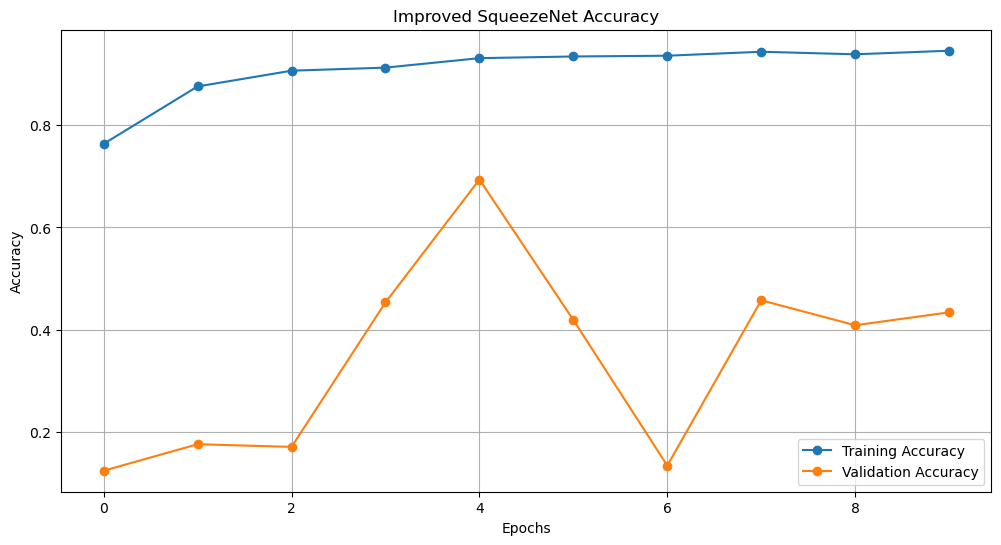

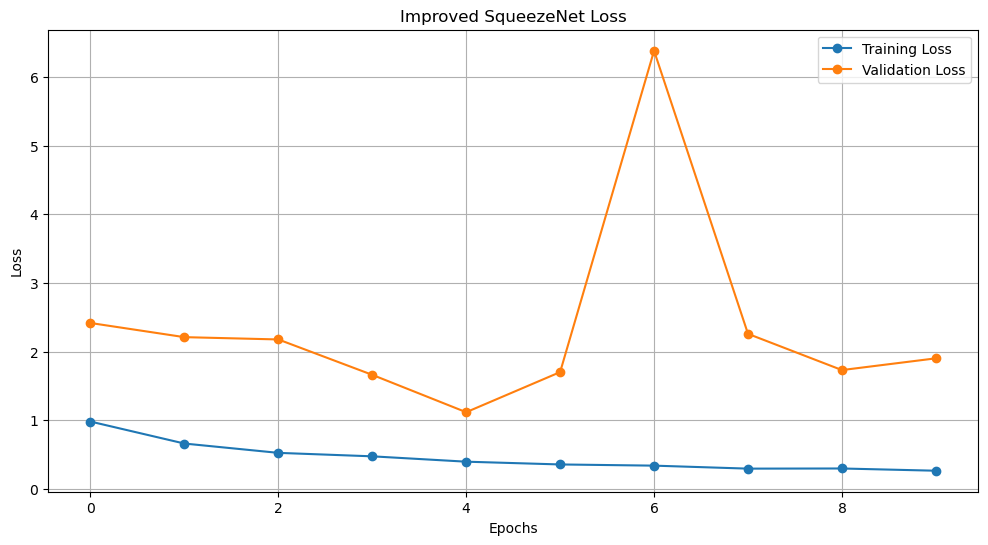

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Build the Improved SqueezeNet model
model_squeezenet = build_improved_squeezenet(input_shape=(128, 128, 3), num_classes=8)

# Display the model summary
model_squeezenet.summary()

# Create sample data generators
# Note: Replace these paths with actual data directories
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Sample data (replace paths with actual directories)
train_generator = train_datagen.flow_from_directory(
    'D:/archive/Mango DataSet1/MangoLeafBD Dataset',  # Replace with your training data path
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'D:/archive/Mango DataSet1/MangoLeafBD Dataset',  # Replace with your validation data path
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Compile the model
model_squeezenet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_squeezenet = model_squeezenet.fit(
    train_generator,
    epochs=15,  # For demonstration, adjust as needed
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_squeezenet.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_squeezenet.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Improved SqueezeNet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_squeezenet.history['loss'], label='Training Loss', marker='o')
plt.plot(history_squeezenet.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Improved SqueezeNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


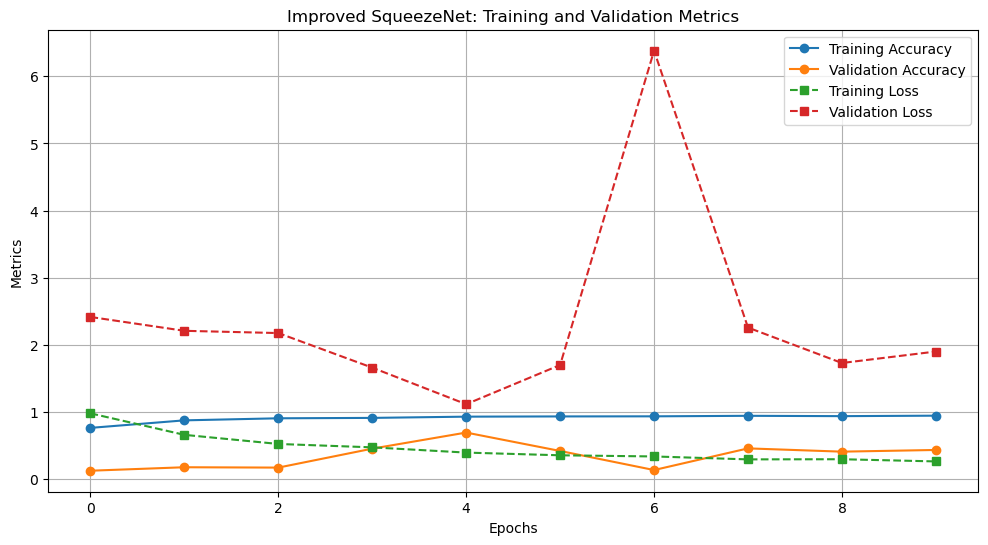

In [37]:
# Plot training and validation accuracy and loss on the same graph
plt.figure(figsize=(12, 6))
plt.plot(history_squeezenet.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_squeezenet.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.plot(history_squeezenet.history['loss'], label='Training Loss', marker='s', linestyle='--')
plt.plot(history_squeezenet.history['val_loss'], label='Validation Loss', marker='s', linestyle='--')

# Add title and labels
plt.title('Improved SqueezeNet: Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load the pretrained MobileNetV3Large model without the top (output) layer
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
model_mobilenetv3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Output for 8 classes
])

# Compile the model
model_mobilenetv3.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_mobilenetv3 = model_mobilenetv3.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)


Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 96s 666ms/step - accuracy: 0.2476 - loss: 1.9342 - val_accuracy: 0.1782 - val_loss: 2.0095
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 625ms/step - accuracy: 0.3919 - loss: 1.5385 - val_accuracy: 0.3562 - val_loss: 1.6843
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 648ms/step - accuracy: 0.4598 - loss: 1.4062 - val_accuracy: 0.5278 - val_loss: 1.4263
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 661ms/step - accuracy: 0.4829 - loss: 1.3724 - val_accuracy: 0.6100 - val_loss: 1.2153
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 681ms/step - accuracy: 0.4994 - loss: 1.3172 - val_accuracy: 0.6447 - val_loss: 1.0737
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 660ms/step - accuracy: 0.5216 - loss: 1.2718 - val_accuracy: 0.6545 - val_loss: 0.9830
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 667ms/step - accuracy: 0.5378 - loss: 1.2251 - val_accuracy: 0.6712 - val_loss: 0.9287
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 670ms/step - accuracy: 0.5305 - loss: 1

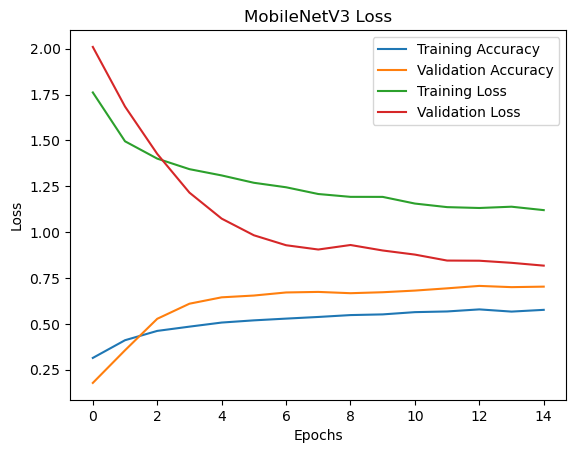

In [52]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history_mobilenetv3.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenetv3.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot training and validation loss
plt.plot(history_mobilenetv3.history['loss'], label='Training Loss')
plt.plot(history_mobilenetv3.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


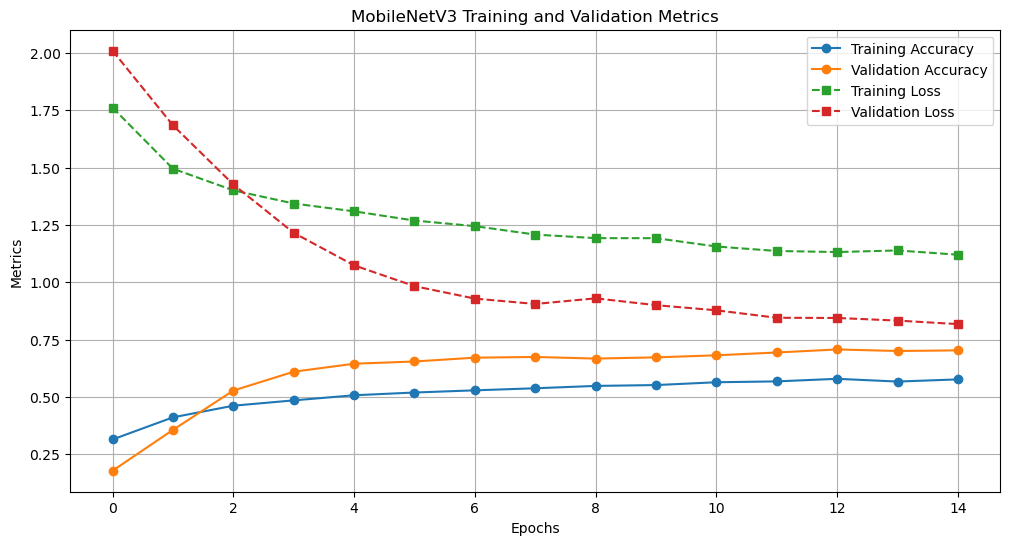

In [73]:
import matplotlib.pyplot as plt

# Plot training and validation metrics on the same graph
plt.figure(figsize=(12, 6))

# Plot training accuracy and validation accuracy
plt.plot(history_mobilenetv3.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_mobilenetv3.history['val_accuracy'], label='Validation Accuracy', marker='o')

# Plot training loss and validation loss
plt.plot(history_mobilenetv3.history['loss'], label='Training Loss', marker='s', linestyle='--')
plt.plot(history_mobilenetv3.history['val_loss'], label='Validation Loss', marker='s', linestyle='--')

# Add title and labels
plt.title('MobileNetV3 Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [54]:
from tensorflow.keras.applications import ResNet101

# Load the pretrained ResNet101 model without the top (output) layer
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
model_resnet101 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Output for 4 classes
])

# Compile the model
model_resnet101.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_resnet101 = model_resnet101.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)


Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 784s 6s/step - accuracy: 0.2465 - loss: 1.9080 - val_accuracy: 0.2397 - val_loss: 1.8956
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 697s 6s/step - accuracy: 0.3734 - loss: 1.5966 - val_accuracy: 0.3560 - val_loss: 1.7155
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 698s 6s/step - accuracy: 0.4378 - loss: 1.4864 - val_accuracy: 0.4532 - val_loss: 1.5214
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 702s 6s/step - accuracy: 0.4424 - loss: 1.4613 - val_accuracy: 0.5822 - val_loss: 1.2838
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 700s 6s/step - accuracy: 0.4673 - loss: 1.3869 - val_accuracy: 0.5753 - val_loss: 1.1937
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 696s 6s/step - accuracy: 0.4818 - loss: 1.3743 - val_accuracy: 0.6075 - val_loss: 1.1151
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 525s 4s/step - accuracy: 0.4747 - loss: 1.3637 - val_accuracy: 0.6102 - val_loss: 1.0969
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 502s 4s/step - accuracy: 0.4858 - loss: 1.3295 - val_accu

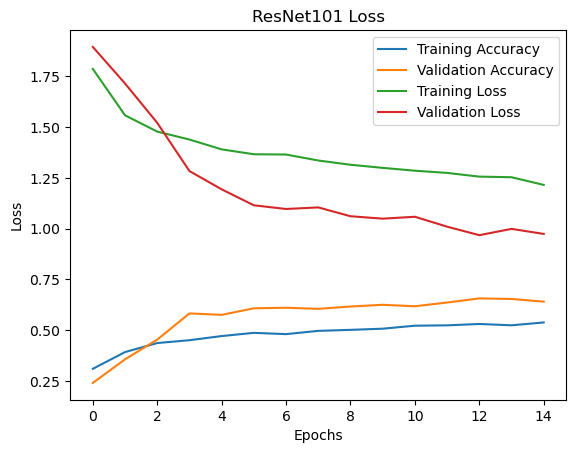

In [55]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history_resnet101.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet101.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet101 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot training and validation loss
plt.plot(history_resnet101.history['loss'], label='Training Loss')
plt.plot(history_resnet101.history['val_loss'], label='Validation Loss')
plt.title('ResNet101 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

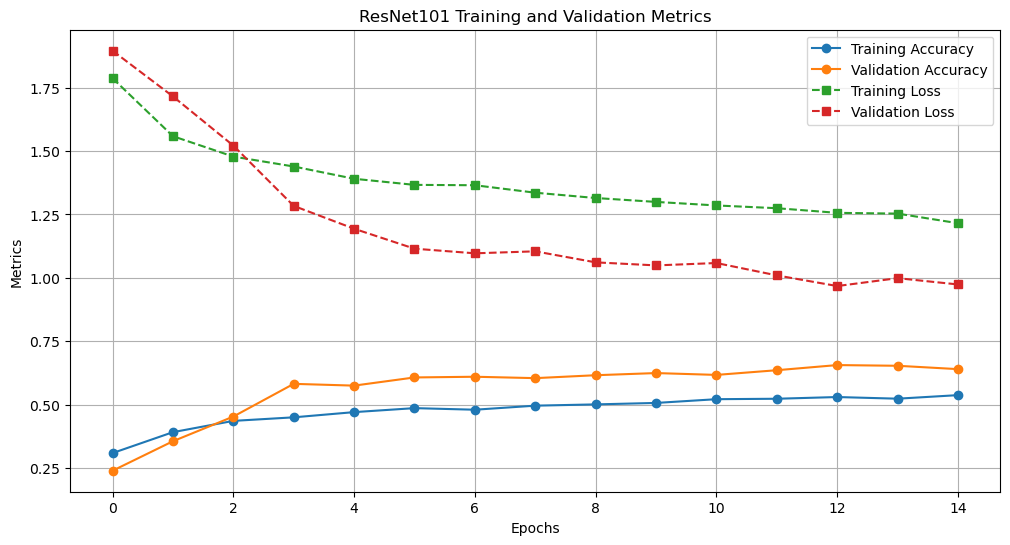

In [75]:
import matplotlib.pyplot as plt

# Plot all metrics in a single graph
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.plot(history_resnet101.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_resnet101.history['val_accuracy'], label='Validation Accuracy', marker='o')

# Plot training and validation loss
plt.plot(history_resnet101.history['loss'], label='Training Loss', marker='s', linestyle='--')
plt.plot(history_resnet101.history['val_loss'], label='Validation Loss', marker='s', linestyle='--')

# Add title, labels, and legend
plt.title('ResNet101 Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [81]:
from tensorflow.keras.applications import ResNet50

# Load the pretrained ResNet50 model without the top (output) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
model_resnet50 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Output for 4 classes
])







# Compile the model
model_resnet50.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [91]:
# Train the model
history_resnet50 = model_resnet50.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.5601 - loss: 1.1722 - val_accuracy: 0.6675 - val_loss: 0.9010
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.5944 - loss: 1.1274 - val_accuracy: 0.6590 - val_loss: 0.9334
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.5897 - loss: 1.1265 - val_accuracy: 0.6710 - val_loss: 0.9129
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.5888 - loss: 1.0932 - val_accuracy: 0.6687 - val_loss: 0.9107
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.5972 - loss: 1.1267 - val_accuracy: 0.6920 - val_loss: 0.8748
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.5828 - loss: 1.1304 - val_accuracy: 0.6718 - val_loss: 0.8919
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.5803 - loss: 1.1103 - val_accuracy: 0.6908 - val_loss: 0.8416
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.5895 - loss: 1.0963 - val_accu

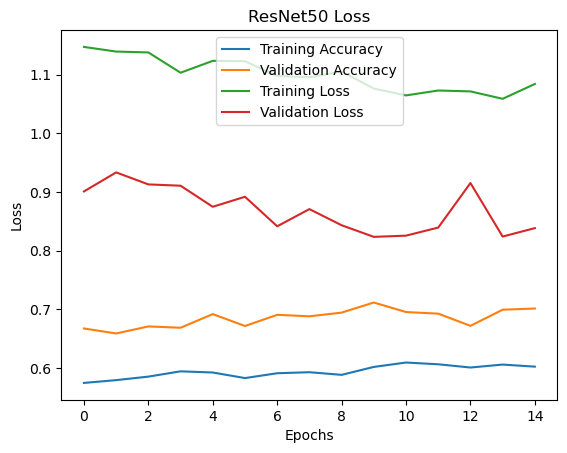

In [95]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Plot training and validation loss
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

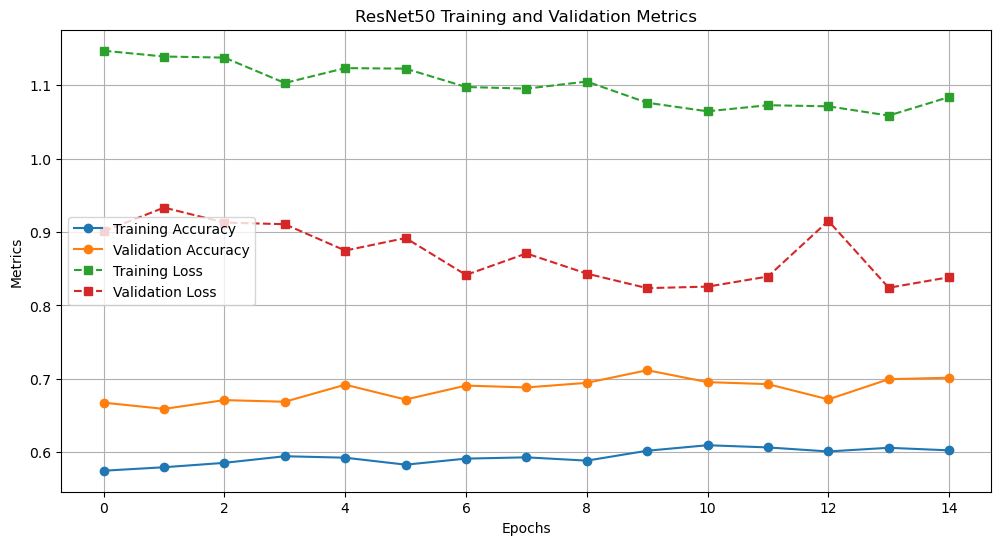

In [97]:
import matplotlib.pyplot as plt

# Create a single plot for all 4 lines
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy', marker='o')

# Plot training and validation loss
plt.plot(history_resnet50.history['loss'], label='Training Loss', marker='s', linestyle='--')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss', marker='s', linestyle='--')

# Add title, labels, and legend
plt.title('ResNet50 Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.4539 - loss: 1.8003 - val_accuracy: 0.8675 - val_loss: 0.4066
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.7326 - loss: 0.8036 - val_accuracy: 0.8920 - val_loss: 0.3209
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.7772 - loss: 0.6568 - val_accuracy: 0.9202 - val_loss: 0.2596
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.8077 - loss: 0.5719 - val_accuracy: 0.9250 - val_loss: 0.2329
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8393 - loss: 0.5036 - val_accuracy: 0.9317 - val_loss: 0.2176
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8330 - loss: 0.5169 - val_accuracy: 0.9385 - val_loss: 0.1991
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.8573 - loss: 0.4260 - val_accuracy: 0.9390 - val_loss: 0.1905
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.8604 - loss: 0.4314 - val_accu

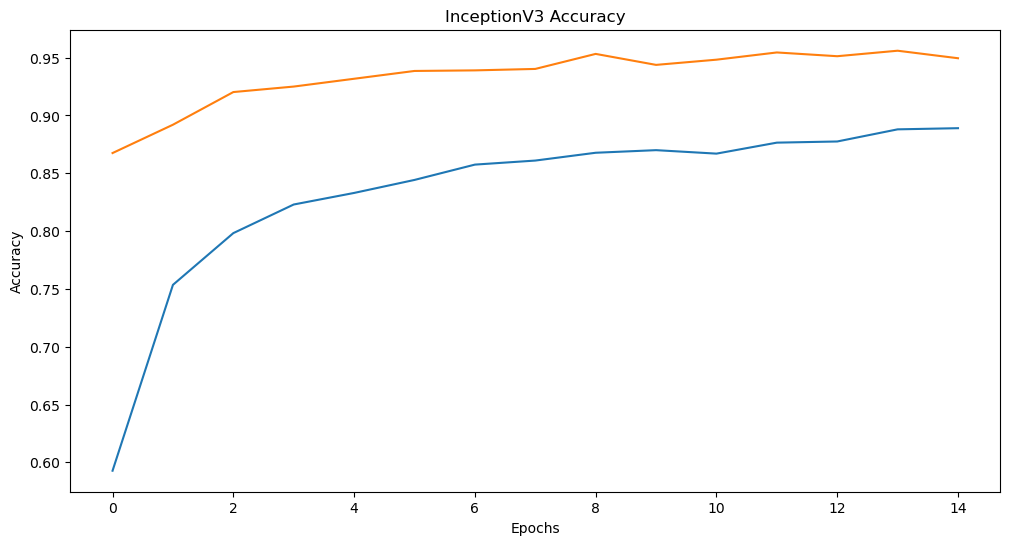

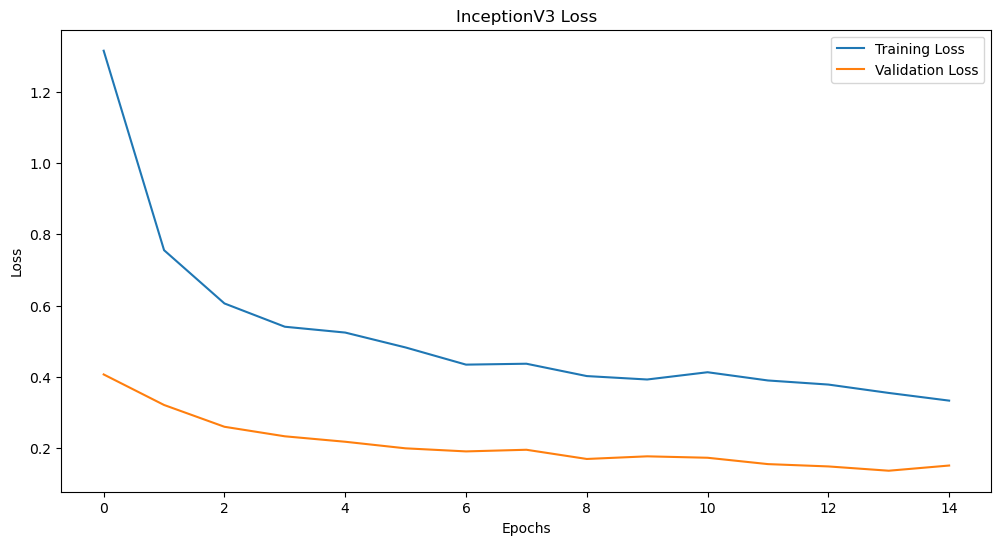

In [65]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the pretrained InceptionV3 model without the top (output) layer
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model_inception.trainable = False

# Add custom layers
model_inception = Sequential([
    base_model_inception,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Output for 4 classes
])

# Compile the model
model_inception.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_inception = model_inception.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.title('InceptionV3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


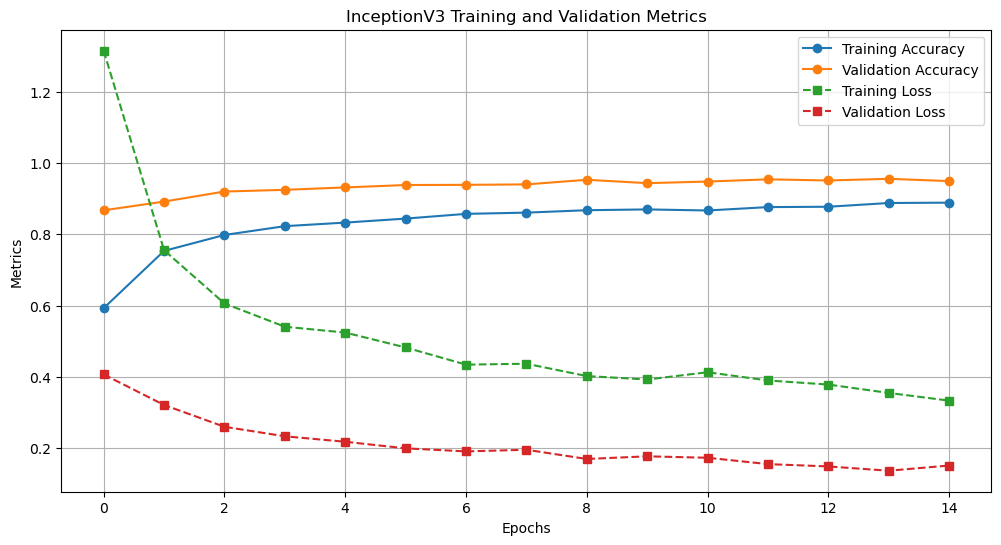

In [99]:
import matplotlib.pyplot as plt

# Create a single plot for both accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.plot(history_inception.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy', marker='o')

# Plot training and validation loss
plt.plot(history_inception.history['loss'], label='Training Loss', marker='s', linestyle='--')
plt.plot(history_inception.history['val_loss'], label='Validation Loss', marker='s', linestyle='--')

# Add title, labels, and legend
plt.title('InceptionV3 Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
Simple SqueezeNet

In [101]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam

def fire_module(x, squeeze_filters, expand_filters):
    """
    Implements a Fire module for SqueezeNet.
    
    Args:
        x: Input tensor.
        squeeze_filters: Number of filters in the squeeze layer.
        expand_filters: Number of filters in the expand layer.
        
    Returns:
        Output tensor of the Fire module.
    """
    # Squeeze layer
    squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='same')(x)
    
    # Expand layer (1x1 and 3x3 convolutions)
    expand1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='same')(squeeze)
    expand3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)
    
    # Concatenate expand layers
    output = concatenate([expand1x1, expand3x3])
    return output

def build_squeezenet(input_shape=(128, 128, 3), num_classes=8):
    """
    Builds the SqueezeNet model.
    
    Args:
        input_shape: Shape of the input images (H, W, C).
        num_classes: Number of output classes.
        
    Returns:
        A Keras Model instance.
    """
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Fire modules
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    
    # Final layers
    x = Dropout(0.5)(x)
    x = Conv2D(num_classes, (1, 1), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    # Create model
    model = Model(inputs, outputs, name="SqueezeNet")
    return model

# Build and compile the model
model_squeezenet = build_squeezenet(input_shape=(128, 128, 3), num_classes=8)
model_squeezenet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_squeezenet = model_squeezenet.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.1219 - loss: 2.0797 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.1302 - loss: 2.0795 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.1246 - loss: 2.0794 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.1309 - loss: 2.0794 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.1199 - loss: 2.0794 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.1237 - loss: 2.0794 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.1309 - loss: 2.0794 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.1214 - loss: 2.0794 - val_accu

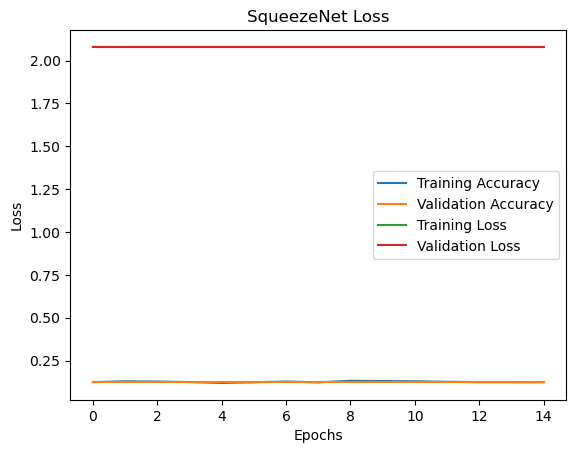

In [103]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history_squeezenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_squeezenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('SqueezeNet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot training and validation loss
plt.plot(history_squeezenet.history['loss'], label='Training Loss')
plt.plot(history_squeezenet.history['val_loss'], label='Validation Loss')
plt.title('SqueezeNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() 



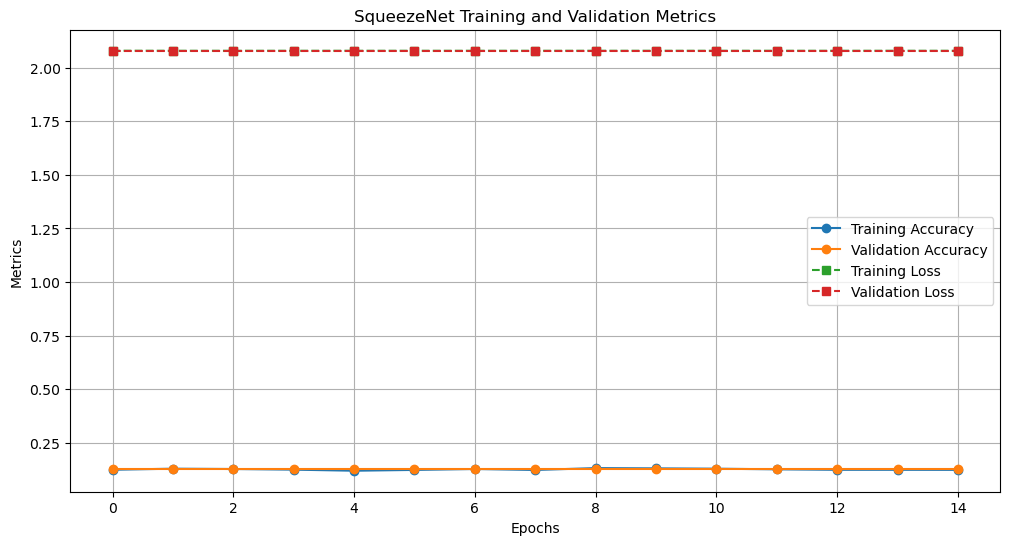

In [105]:
import matplotlib.pyplot as plt

# Create a single plot for both accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.plot(history_squeezenet.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_squeezenet.history['val_accuracy'], label='Validation Accuracy', marker='o')

# Plot training and validation loss
plt.plot(history_squeezenet.history['loss'], label='Training Loss', marker='s', linestyle='--')
plt.plot(history_squeezenet.history['val_loss'], label='Validation Loss', marker='s', linestyle='--')

# Add title, labels, and legend
plt.title('SqueezeNet Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [107]:
def evaluate_model(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    cr = classification_report(y_true, y_pred_classes, target_names=generator.class_indices.keys())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=generator.class_indices.keys(), yticklabels=generator.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print('Classification Report:')
    print(cr)

125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 548ms/step


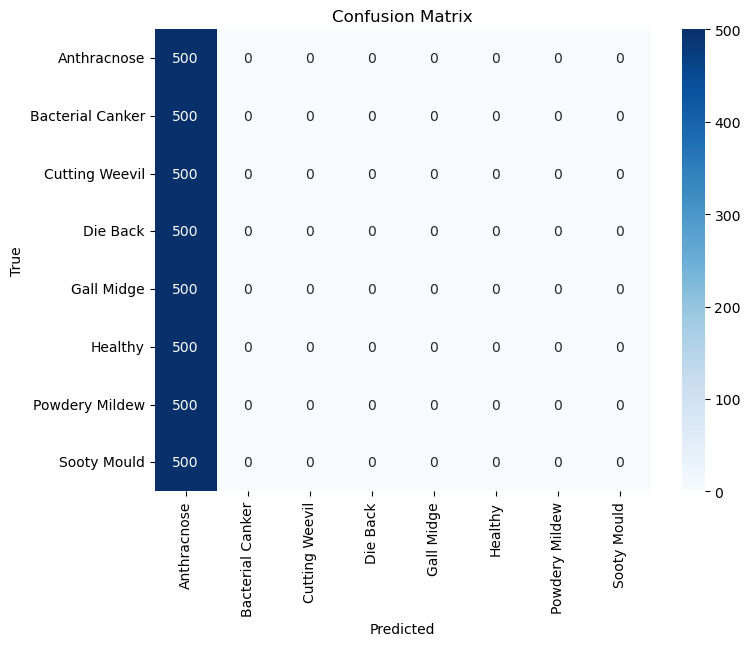

Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       0.12      1.00      0.22       500
Bacterial Canker       0.00      0.00      0.00       500
  Cutting Weevil       0.00      0.00      0.00       500
        Die Back       0.00      0.00      0.00       500
      Gall Midge       0.00      0.00      0.00       500
         Healthy       0.00      0.00      0.00       500
  Powdery Mildew       0.00      0.00      0.00       500
     Sooty Mould       0.00      0.00      0.00       500

        accuracy                           0.12      4000
       macro avg       0.02      0.12      0.03      4000
    weighted avg       0.02      0.12      0.03      4000



In [109]:
evaluate_model(model_squeezenet, val_generator)

125/125 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step


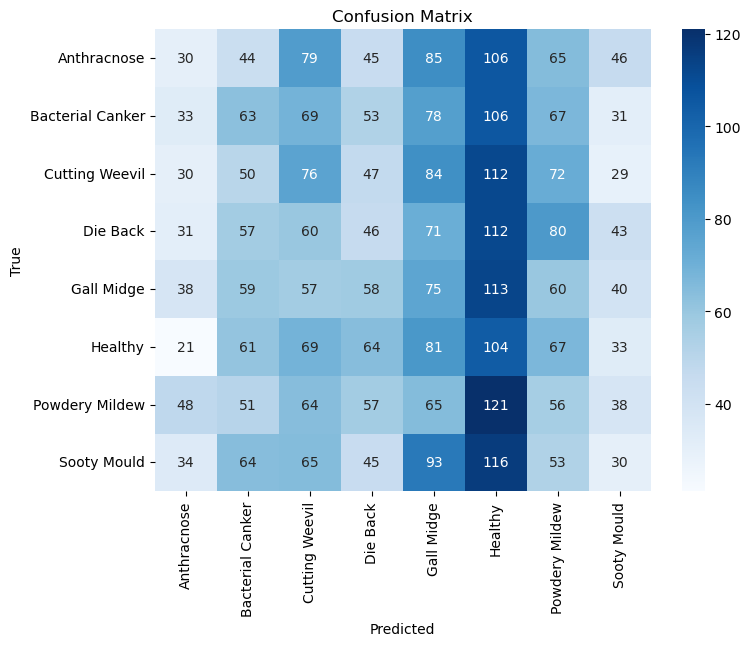

Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       0.11      0.06      0.08       500
Bacterial Canker       0.14      0.13      0.13       500
  Cutting Weevil       0.14      0.15      0.15       500
        Die Back       0.11      0.09      0.10       500
      Gall Midge       0.12      0.15      0.13       500
         Healthy       0.12      0.21      0.15       500
  Powdery Mildew       0.11      0.11      0.11       500
     Sooty Mould       0.10      0.06      0.08       500

        accuracy                           0.12      4000
       macro avg       0.12      0.12      0.12      4000
    weighted avg       0.12      0.12      0.12      4000



In [111]:
evaluate_model(model_resnet50, val_generator)

125/125 ━━━━━━━━━━━━━━━━━━━━ 464s 3s/step


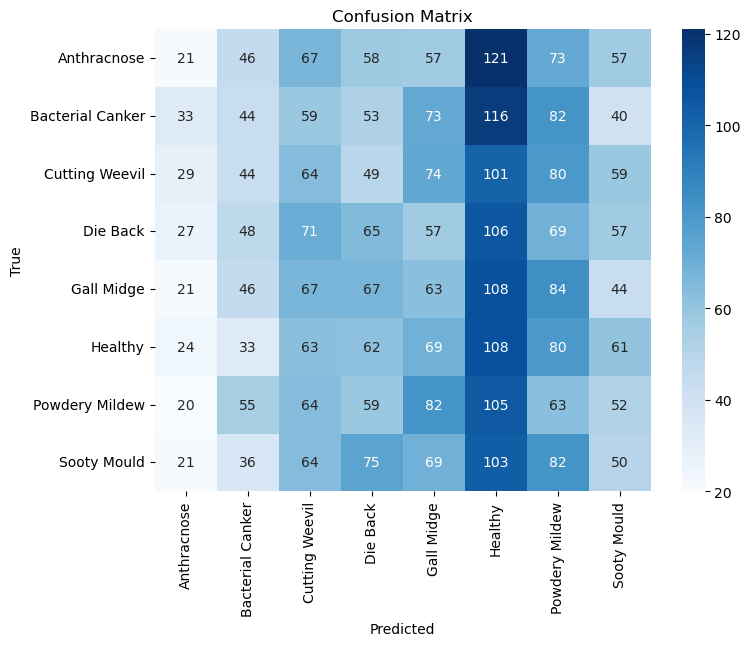

Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       0.11      0.04      0.06       500
Bacterial Canker       0.12      0.09      0.10       500
  Cutting Weevil       0.12      0.13      0.13       500
        Die Back       0.13      0.13      0.13       500
      Gall Midge       0.12      0.13      0.12       500
         Healthy       0.12      0.22      0.16       500
  Powdery Mildew       0.10      0.13      0.11       500
     Sooty Mould       0.12      0.10      0.11       500

        accuracy                           0.12      4000
       macro avg       0.12      0.12      0.12      4000
    weighted avg       0.12      0.12      0.12      4000



In [113]:
evaluate_model(model_resnet101, val_generator)

125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 342ms/step


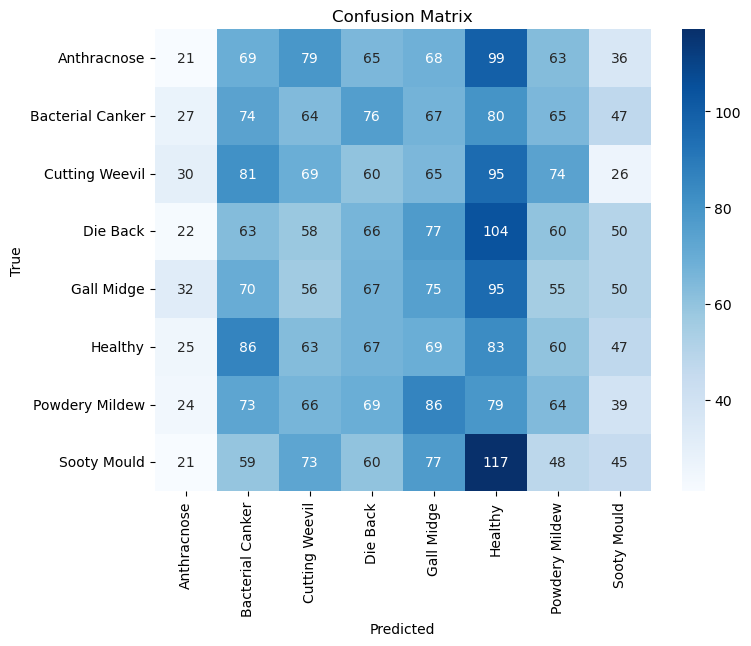

Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       0.10      0.04      0.06       500
Bacterial Canker       0.13      0.15      0.14       500
  Cutting Weevil       0.13      0.14      0.13       500
        Die Back       0.12      0.13      0.13       500
      Gall Midge       0.13      0.15      0.14       500
         Healthy       0.11      0.17      0.13       500
  Powdery Mildew       0.13      0.13      0.13       500
     Sooty Mould       0.13      0.09      0.11       500

        accuracy                           0.12      4000
       macro avg       0.12      0.12      0.12      4000
    weighted avg       0.12      0.12      0.12      4000



In [115]:
evaluate_model(model_mobilenetv3, val_generator)

125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 918ms/step


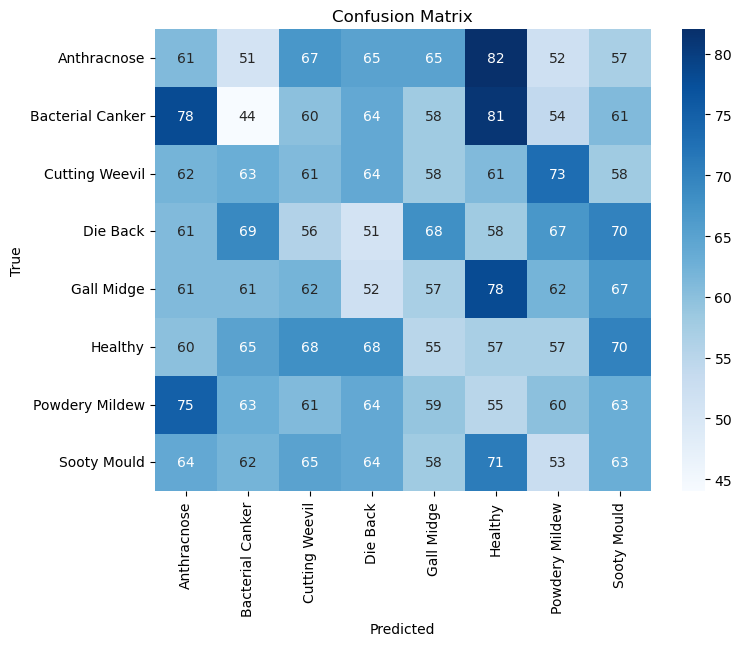

Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       0.12      0.12      0.12       500
Bacterial Canker       0.09      0.09      0.09       500
  Cutting Weevil       0.12      0.12      0.12       500
        Die Back       0.10      0.10      0.10       500
      Gall Midge       0.12      0.11      0.12       500
         Healthy       0.10      0.11      0.11       500
  Powdery Mildew       0.13      0.12      0.12       500
     Sooty Mould       0.12      0.13      0.12       500

        accuracy                           0.11      4000
       macro avg       0.11      0.11      0.11      4000
    weighted avg       0.11      0.11      0.11      4000



In [121]:
evaluate_model(model_inception, val_generator)

In [129]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Function to compute and plot ROC curve
def plot_roc_curve(models, generator, num_classes):
    """
    Plots the ROC curve for multiple models.

    Args:
        models: A dictionary of model names and trained model instances.
        generator: The test/validation generator.
        num_classes: Number of output classes.

    Returns:
        None
    """
    # Get true labels
    true_labels = generator.classes  # True labels from the generator
    class_labels = list(generator.class_indices.keys())  # Class names
    
    # One-hot encode the true labels
    from tensorflow.keras.utils import to_categorical
    true_labels_one_hot = to_categorical(true_labels, num_classes=num_classes)
    
    # Plot ROC for each model
    plt.figure(figsize=(10, 8))
    
    for model_name, model in models.items():
        # Get predicted probabilities
        predictions = model.predict(generator)
        
        # Compute ROC curve and AUC for each class
        fpr = {}
        tpr = {}
        roc_auc = {}
        
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and AUC
        fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_one_hot.ravel(), predictions.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Plot the micro-average ROC curve
        plt.plot(
            fpr["micro"], tpr["micro"],
            label=f'{model_name} (AUC = {roc_auc["micro"]:.2f})',
            linewidth=2
        )
    
    #Plot diagonal (random classifier)
    #plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
    
    # Customize plot
    plt.title("ROC Curve Comparison", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid()
    plt.show()




125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 321ms/step


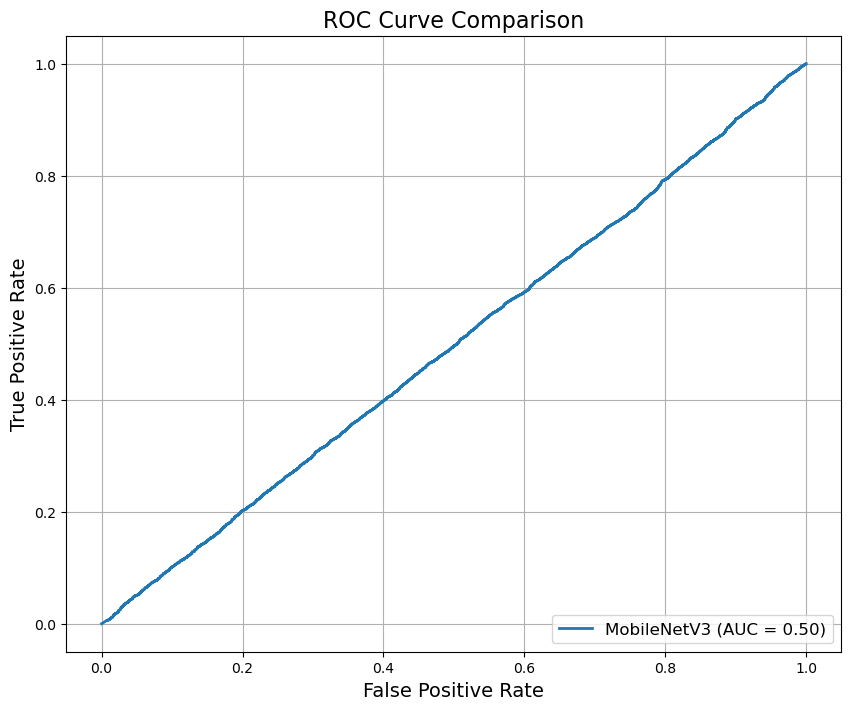

In [131]:
# Dictionary of models
models = {
 
    "MobileNetV3": model_mobilenetv3,
   
    
}

# Plot ROC curves
plot_roc_curve(models, val_generator, num_classes=8)

125/125 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step


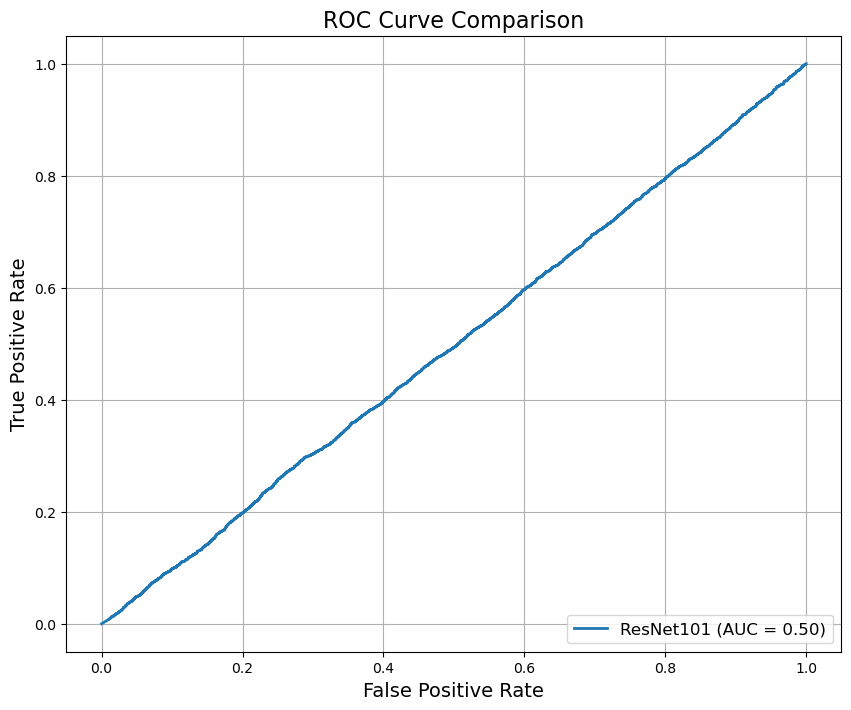

In [139]:
models = {
 
    "ResNet101": model_resnet101,
   
    
}
plot_roc_curve(models, val_generator, num_classes=8)

125/125 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step


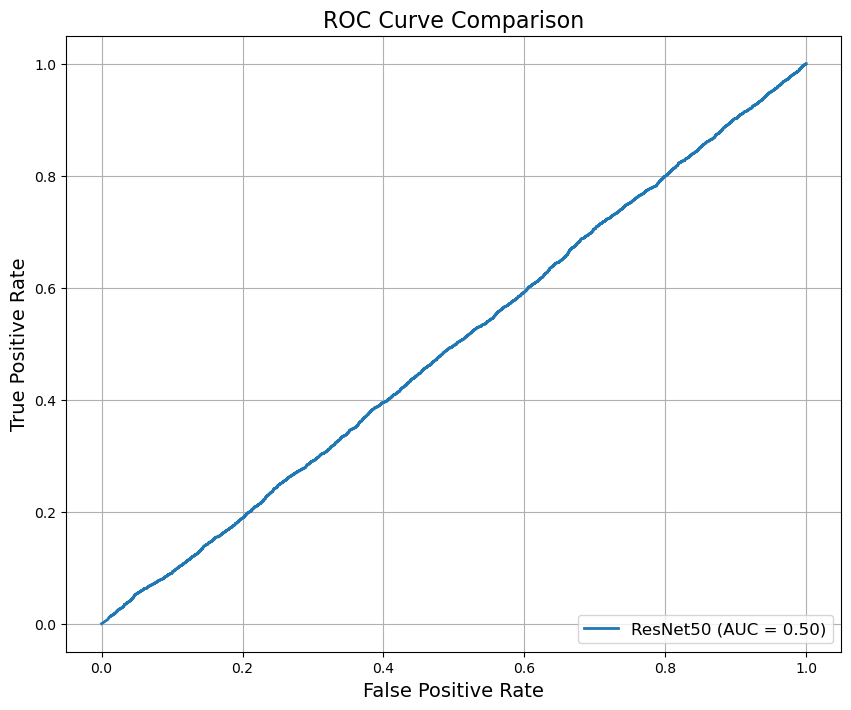

In [140]:
models = {
 
    "ResNet50": model_resnet50,
    
}
plot_roc_curve(models, val_generator, num_classes=8)

125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 562ms/step


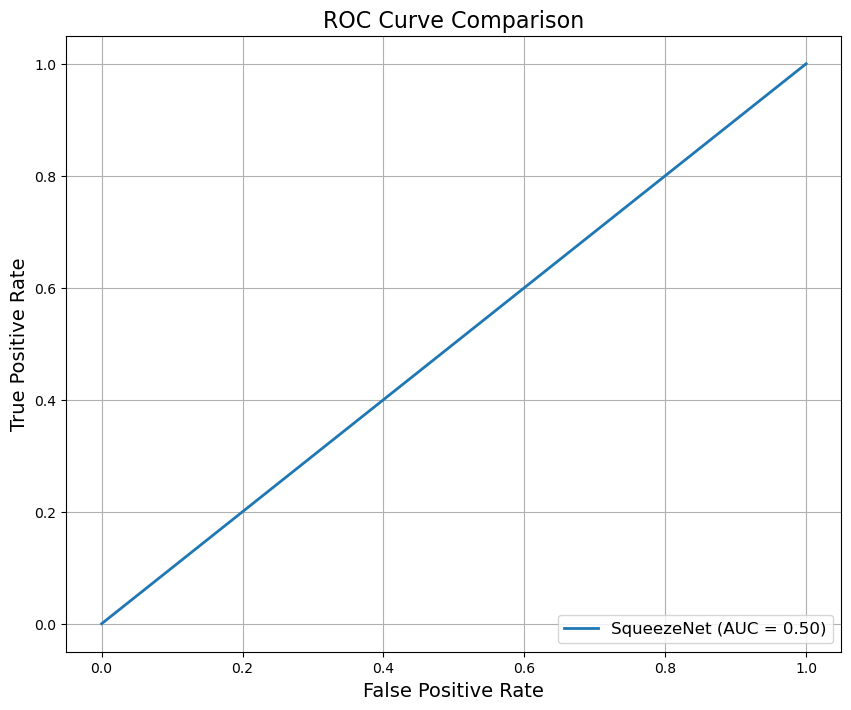

In [141]:
models = {
 
    "SqueezeNet": model_squeezenet,
   
    
}
plot_roc_curve(models, val_generator, num_classes=8)